<a href="https://colab.research.google.com/github/soheldatta17/Knee-Arthritis-Detection/blob/main/knee_arthritis_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://www.moati.com.au/wp-content/uploads/2022/05/knee-arthritis-surgery.jpg)

# Initial Imports

In [1]:
import tensorflow
import numpy as np
import keras
import cv2,os

# Data Preprocessing

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d hafiznouman786/annotated-dataset-for-knee-arthritis-detection -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/annotated-dataset-for-knee-arthritis-detection
License(s): CC0-1.0
 91% 53.0M/58.3M [00:00<00:00, 179MB/s]
100% 58.3M/58.3M [00:00<00:00, 181MB/s]


In [4]:
import os
os.listdir("/content/Training")

['3Moderate', '4Severe', '1Doubtful', '0Normal', '2Mild']

In [5]:
data_path='/content/Training'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'3Moderate': 0, '4Severe': 1, '1Doubtful': 2, '0Normal': 3, '2Mild': 4}
['3Moderate', '4Severe', '1Doubtful', '0Normal', '2Mild']
[0, 1, 2, 3, 4]


In [6]:
img_size=256
data=[]
label=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)

    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the image  into 256 x 256, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            label.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

# Rescale and assign  catagorical labels

In [7]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
label=np.array(label)

from keras.utils import to_categorical
new_label= to_categorical(label)

In [8]:
new_label.shape

(1650, 5)

In [9]:
data.shape

(1650, 256, 256, 1)

In [10]:
data.shape[1:]

(256, 256, 1)

# Model Creation

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(128, (3, 3), input_shape=data.shape[1:], kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer='he_normal', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))  # Slightly increased dropout to prevent overfitting

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))

# Ensure the output layer has the correct number of units and activation function
model.add(Dense(5, activation='softmax')) # Output layer with 5 units for 5 classes and softmax activation

optimizer = Adam(learning_rate=0.0005)  # Slightly reduced learning rate for stability

# Explicitly define loss and metrics in compile
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Summary

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 254, 254, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 125, 125, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,789,541 (14.46 MB)

 Trainable params: 3,789,093 (14.45 MB)

 Non-trainable params: 448 (1.75 KB)

# Splitting data into traning and testing

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)


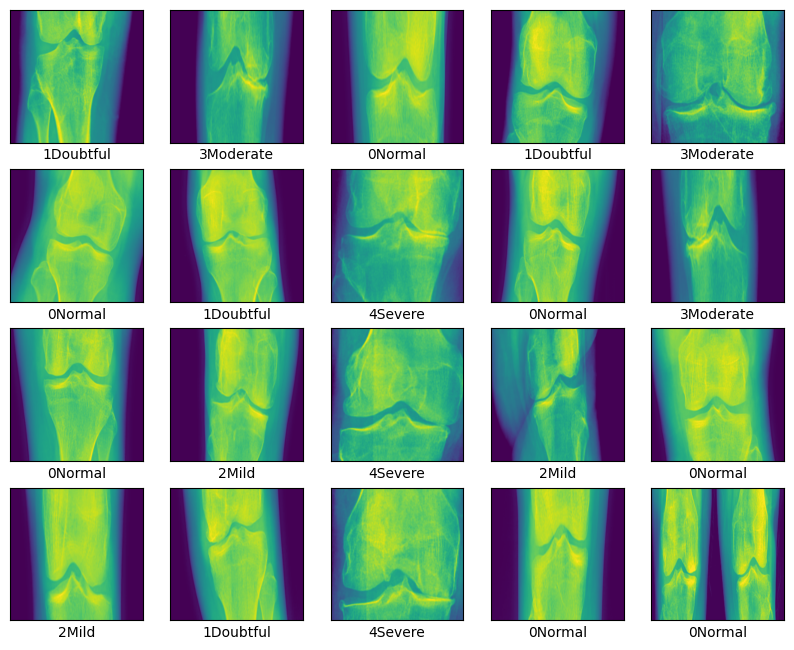

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

# Model Training

In [15]:
import tensorflow as tf
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


In [16]:
history=model.fit(x_train, y_train, epochs=40, validation_split=0.2, batch_size=32)

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 235ms/step - accuracy: 0.2413 - loss: 3.9321 - val_accuracy: 0.1515 - val_loss: 4.0811
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3301 - loss: 1.9965 - val_accuracy: 0.2311 - val_loss: 2.2196
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.3699 - loss: 1.9051 - val_accuracy: 0.3750 - val_loss: 1.8822
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4095 - loss: 1.7621 - val_accuracy: 0.4356 - val_loss: 1.8357
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.4412 - loss: 1.7314 - val_accuracy: 0.3333 - val_loss: 1.9501
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.4702 - loss: 1.6507 - val_accuracy: 0.2500 - val_loss: 2.2336
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.5082 - loss: 1.5836 - val_accuracy: 0.2045 - val_loss: 2.2648
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.5582 - loss: 1.4958 - val_accuracy: 0

# Plot The Training Loss And Accuracy

In [17]:
from matplotlib import pyplot as plt

# Accuracy

In [19]:
vaL_loss, val_accuracy= model.evaluate(x_test, y_test, verbose=0)
print("test loss:", vaL_loss,'%')
print("test accuracy:", val_accuracy,"%")

test loss: 1.759631872177124 %
test accuracy: 0.5696969628334045 %


# Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
A.I predicts: 1Doubtful
Correct prediction for label 2 is 1Doubtful


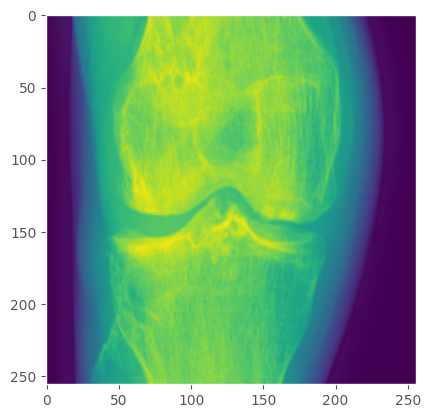

In [20]:
X = 32

img_size = 256

img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0],256,256,1)

predictions_single = model.predict(img_single)
print('A.I predicts:',categories[np.argmax(predictions_single)])
print("Correct prediction for label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

# Confusion Matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


<Figure size 640x480 with 0 Axes>

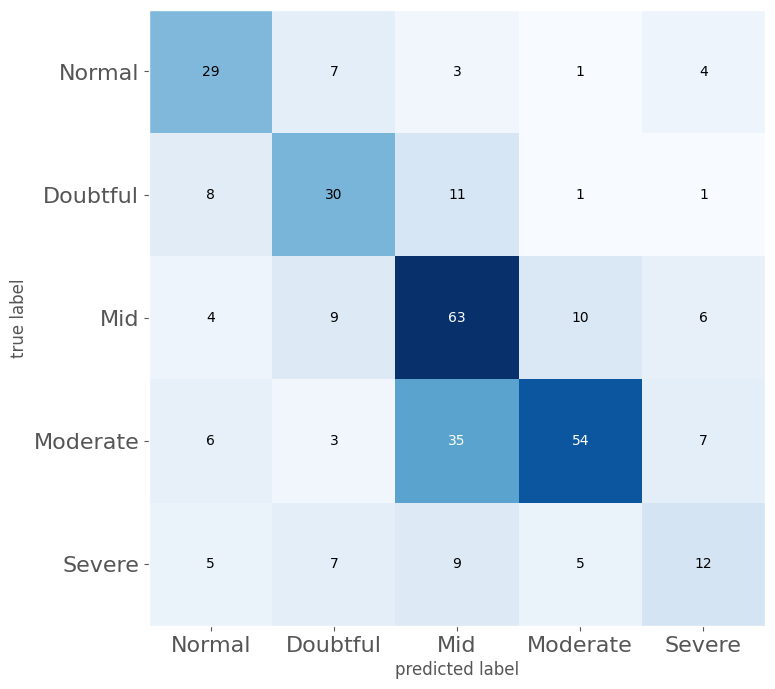

In [21]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)


cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.yticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.show()